In [116]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random

In [272]:
class Circuit:
    def __init__(self,n):
        self.n = n
        self.wires = [Wire(k) for k in range(n)]
        self.gates = []
        
    def addGate(self,g):
        self.gates.append(g)
        for bit in g.bits:
            self.wires[bit].addGate(g)
    
    def __str__(self):
        string = ""
        for gate in self.gates:
            string = string + str(gate)
            
        return string
        
    def fullStoch(self,state=[]):
        if state == []:
            state = np.zeros(self.n)
        state = state2dist(self.n,state)
        for gate in self.gates:
            state = gate.fullStoch(self.n) @ state
        return state
    
    
    def printWires(self):
        for wire in self.wires:
            print(wire)
            
    def fireShot(self,state=[]):
        if state == []:
            state = np.zeros(self.n)
            
        for gate in self.gates:
            gate_state = [state[b] for b in gate.bits]
            gate_state = gate.fireLocal(gate_state)
            for i in range(len(gate_state)):
                state[gate.bits[i]] = gate_state[i]
        return state
        
    def expectationShots(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        runningtotal = self.fireShot()
        for i in range(numshots-1):
            runningtotal = runningtotal + self.fireShot()
        
        return [x / numshots for x in runningtotal]
    
    def shotsDist(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        histstates = {}
        for i in range(numshots):
            state = self.fireShot()
            ind = 0
            for k in range(len(state)):
                ind += 2**k * state[k] 
            ind = int(ind)
            if ind in histstates:
                histstates[ind] += 1
            else:
                histstates[ind] = 1
        for k in histstates:
            histstates[k] /= numshots
        return histstates
    
    def shotsDistHist(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        histstates = np.zeros(2**self.n)
        xs = np.zeros(2**self.n)
        
        for i in range(numshots):
            state = self.fireShot()
            ind = 0
            for k in range(len(state)):
                 ind += 2**k * state[k] 
            histstates[ind] += 1
            xs[ind] = ind
        hist = plt.bar(xs,histstates)
        return hist
        
class Wire:
    def __init__(self,k):
        self.k = k
        self.gates = []
    
    def addGate(self,g):
        self.gates.append(g)
    
    def removeLastGate(self):
        return self.gates.pop()
    
    def __str__(self):
        string = f"[{self.k}]:"
        for gate in self.gates:
            string += str(gate)
        return string

class Gate:
    #assumes if bits = (0,1,2), order is kron(b2,b1,b0).  This follows from c01 gate having control
    #on 0 and target on 1 by convention
    gatecount = 0

    def __init__(self,matrix,bits):
        assert(matrix.shape == (2**len(bits),2**len(bits)))
        self.matrix = matrix
        self.bits = bits
        self.id = Gate.gatecount
        Gate.gatecount += 1
        
    def __str__(self):
        return f"-g{self.id}-"
    
    
    def fireLocal(self,state):
        #TODO: verify that this is resilient to weird ordered qubits
        state_dist = state2dist(len(state),state)
        new_dist = np.dot(self.matrix,state_dist);
        new_state = sampledist(len(state),new_dist)
        return new_state;
    
    def fullStoch(self,n):
        #TODO: optimize for adjacent bit states (no swaps required)
        #first construct hamiltonian operating on first len(bits) qubits, then swap bits to fit order
        stoch = self.matrix
        for i in range(n - len(self.bits)):
            stoch = np.kron([[1,0],[0,1]],stoch)
            
        swaps = Gate._swapcircuit(self,n)
        if len(swaps):
            stoch = np.dot(stoch, np.transpose(swaps))
            stoch = np.dot(swaps, stoch)
            
        return stoch
    
    def _swapcircuit(self,n):
        swaplist = Gate._bubbleSortOperations(self.bits) 
        sortedbits = sorted(self.bits)
        for i in range(len(sortedbits)-1,-1,-1):
            if not (i == sortedbits[i]):
                swaplist.append((i,sortedbits[i]))
        return Gate._swapStoch(self,n,swaplist)
    
    
    def _swapStoch(self,n,swaplist):
        swapMatrix =  []
        if not (len(swaplist) == 0):
            swapMatrix = np.eye(2**n)
            for swapbits in swaplist:
                swapMatrix = np.dot(Gate._generateSwapMatrix(n,swapbits),swapMatrix)
        return swapMatrix
    
    def _generateSwapMatrix(n,swapbits):
        N = 2**n
        swapMat = np.zeros((N,N))
        for i in range(N):
            mask1 = i >> swapbits[0] & 1
            mask2 = i >> swapbits[1] & 1
            xor = mask1 ^ mask2
            xor = xor << swapbits[0] | xor << swapbits[1]
            j = i ^ xor
            swapMat[i,j] = 1
        return swapMat
    
    def _bubbleSortOperations(bits):
        issorted = False
        swaplist = []
        while not issorted:
            issorted = True
            for i in range(len(bits) - 1):
                if bits[i] > bits[i+1]:
                    temp = bits[i]
                    bits[i] = bits[i+1]
                    bits[i+1] = temp
                    issorted = False
                    swaplist.append((i,i+1))
        return swaplist

def state2dist(n,state):
    ##reverse marginal calculation, assuming no correlation
    #state in form: [probBit0, probBit1, ..., probBitn] == ones(n)
    #simialr to a bit string
    #dist in form [probState0,probState1, ..., probStaten]
    #similar to quantum state
    dist = np.zeros(2**n)
    for i in range(2**n):
        iprob = 1;
        for k in range(n):
            if (1 << k) & i:
                iprob *= state[k]
            else:
                iprob *= 1.0 - state[k]
        dist[i] = iprob
    return dist
            
        
def dist2state(n,dist):
    ##Effectively a marginal calculation
    #dist in form [probState0,probState1, ..., probStaten]
    #similar to quantum state
    #state in form: [probBit0, probBit1, ..., probBitn] == ones(n)
    #similar to a bit string
    outstate = np.zeros(n);
    for i in range(2**n):
        for k in range(n):
            outstate[k] += (((1 << k) & i)>>k) * dist[i]
            
    return outstate
            
def sampledist(n,dist):
    choices = [i for i in range(2**n)]
    choice = np.random.choice(choices,p=dist)
    state = np.zeros(n)
    for i in range(n):
        state[i] += (((1 << i) & choice) >> i)
    return state

def randomStochMatrix(n):
    mat = np.random.rand(2**n,2**n)
    mat = mat/mat.sum(axis = 0)
    return mat

def stateHistogram(n,dist):
    assert (type(dist) == np.ndarray or type(dist) == dict), "Invalid type for plotting.  Must be np.ndarray or dict"
    if type(dist) == dict:
        xs = [k for k in dist]
        xs.sort()
        ys = [dist[k] for k in xs]
        fig, ax = plt.subplots()
        ax.bar(xs,ys)
        plt.title("Sampled Distribution")
        plt.xlabel("state")
        plt.ylabel("prob")
        
        xtickformat = '0' + str(n) + 'b'
        xticks = [str(format(x, xtickformat)) for x in xs]
        
        ax.set_xticks(range(len(xticks)))
        ax.set_xticklabels(xticks,rotation="vertical")
        return fig
    else:
        xs = dist.nonzero()
        ys = np.array(dist[xs])
        xs = xs[0]
        print(xs)
        print()
        print(ys)
        fig, ax = plt.subplots()
        ax.bar(xs,ys)
        plt.title("True Distribution")
        plt.xlabel("state")
        plt.ylabel("prob")
        
        xtickformat = '0' + str(n) + 'b'
        xticks = [str(format(x, xtickformat)) for x in xs]
        
        ax.set_xticks(range(len(xticks)))
        ax.set_xticklabels(xticks,rotation="vertical")
        return fig

def randomConnectedGraph(n):
    #returns a random connected 3-regular graph
    G = nx.generators.random_graphs.random_regular_graph(3,n)
    while not nx.is_connected(G):
        G = nx.generators.random_graphs.random_regular_graph(3,n);
        
    #relabelling to fix read/write issues (reads nodes in different order producing wrong
    #adjacency matrix)
    mapping = dict(zip(G,sorted(G)))
    G = nx.relabel_nodes(G, mapping)
    return G

def readGraph(path):
    file = open(path,'r')
    G = nx.Graph()
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            G.add_node(int(labels[0]))
    file.seek(0)
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            edges = [(int(labels[0]),int(labels[i])) for i in range(1,len(labels))]
            G.add_edges_from(edges)
    file.close()
    return G

def writeGraph(G,path):
    nx.write_adjlist(G,path)
    
def graphMatrix(G):
    return nx.adjacency_matrix(G)

def graphCutBin(G,vec):
    vec = np.array(vec)
    vec = 1 - 2*vec
    return graphCutIsing(G,vec);

def graphCutIsing(G,vec):
    #use mat.size instead of np.sum(mat) for speed. since all weights are 1 in matrix.
    vec = np.array([vec])
    mat = graphMatrix(G)
    return (mat.size - (vec @ mat @ vec.T)[0][0])/4
    

Gates:
-g36--g37--g38-

Wires:
[0]:-g36--g38-
[1]:-g36--g37-
[2]:-g38-
[3]:
[4]:

Shot Distribution:
[0, 1, 2, 3, 4, 5, 6, 7]
00000  =>  0.0564
00001  =>  0.0805
00010  =>  0.0666
00011  =>  0.0929
00100  =>  0.0628
00101  =>  0.2601
00110  =>  0.0753
00111  =>  0.3054

True Distribution:
00000  =>  0.05689903902944693
00001  =>  0.08067091959893344
00010  =>  0.06621533790997297
00011  =>  0.09397790562753808
00100  =>  0.06438295689174728
00101  =>  0.2601539449736026
00110  =>  0.0749203489107132
00111  =>  0.30277954705804555
[0 1 2 3 4 5 6 7]

[0.05689904 0.08067092 0.06621534 0.09397791 0.06438296 0.26015394
 0.07492035 0.30277955]

Graph Examples
Graph (original):
[(0, 1), (0, 5), (0, 7), (1, 4), (1, 3), (2, 3), (2, 4), (2, 7), (3, 5), (4, 6), (5, 6), (6, 7)]
Graph (from file):
[(0, 1), (0, 5), (0, 7), (1, 4), (1, 3), (2, 3), (2, 4), (2, 7), (3, 5), (4, 6), (5, 6), (6, 7)]
Cut Examples on Crossed Square Graph:
[1, 1, 1, 1]
cut:  0.0

[0, 0, 0, 0]
cut:  0.0

[1, 1, 0, 0]
cut:  4.

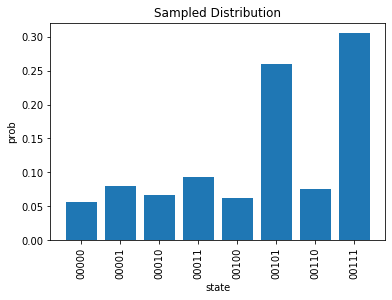

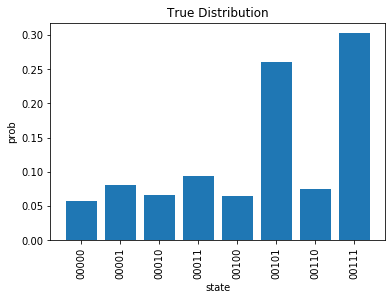

In [293]:
#convergence checking for V&V
n = 5
circ = Circuit(n)
m1 = randomStochMatrix(2)
g1 = Gate(m1,[0,1])

m2 = randomStochMatrix(1)
g2 = Gate(m2,[1])

m3 = randomStochMatrix(2)
g3 = Gate(m3,[0,2])

circ.addGate(g1)
circ.addGate(g2)
circ.addGate(g3)

print("Gates:")
print(circ)
print()

print("Wires:")
circ.printWires()

print()

print("Shot Distribution:")
dist = circ.shotsDist(10000)

distkeys = [k for k in dist]
distkeys.sort()
print(distkeys)
for k in distkeys:
    binformat = '0' + str(circ.n) + 'b'
    print(format(k, binformat) , " => ", dist[k])

print()
print("True Distribution:")
state = circ.fullStoch()
for k in distkeys:
    binformat = '0' + str(circ.n) + 'b'
    print(format(k,binformat), " => ", state[k])

stateHistogram(n,dist)
stateHistogram(n,state)

## Graph Example
random.seed(123)
np.random.seed(456)
print()
print("Graph Examples")
G_8 = randomConnectedGraph(8)
print("Graph (original):")
print(G_8.edges)

writeGraph(G,"graph_example.adjlist")
G_8_read = readGraph("graph_example.adjlist")

print("Graph (from file):")
print(G_8_read.edges)

G4 = randomConnectedGraph(4)
print("Cut Examples on Crossed Square Graph:")

vec = [1,1,1,1]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [0,0,0,0]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [1,1,0,0]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [1,-1,1,-1]
print(vec)
print("cut: ", graphCutIsing(G4,vec))
print()

vec = [1,-1,-1,-1]
print(vec)
print("cut: ", graphCutIsing(G4,vec))

[0 1 2 3 4 5 6 7]

[0.05689904 0.08067092 0.06621534 0.09397791 0.06438296 0.26015394
 0.07492035 0.30277955]


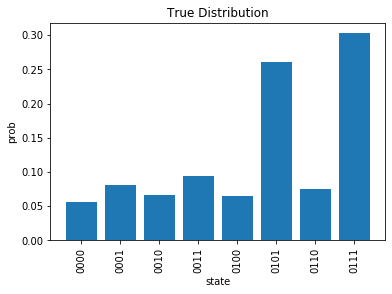

In [213]:
state = circ.fullStoch()
fig = stateHistogram(4,state)

In [214]:
def genRand3Reg(n):
    assert(n >= k+1 and 3*n % 2 == 0), "Invalid number of vertices: k*n must be even and n >= k+1"
    #first construct a minimum spanning tree, then add random edges
    graph = randMinSpanningTree(n,k=k-1)
    
def randBinSpanningTree(n):
    vertices = np.array([v for v in range(n)])
    #np.random.shuffle(vertices)
    return generateBinTree(vertices)

def generateBinTree(arr):
    #generates a binary tree with a breadth first traversal
    arr = np.array(arr)
    assert(type(arr) == np.ndarray)
    graph = []
    length = arr.size
    for i in range(length):
        if(2*i+1 < length):
            graph.append(sorted((arr[i],arr[2*i+1])))
        if(2*i+2 < length):
            graph.append(sorted((arr[i],arr[2*i+2])))
    return graph

In [215]:
randBinSpanningTree(6)

[[0, 1], [0, 2], [1, 3], [1, 4], [2, 5]]

In [216]:
a = [0,1,2]
b = a.pop()
print(a)
print(b)

[0, 1]
2


In [217]:
C10.matrix

NameError: name 'C10' is not defined

In [218]:
circ.addGate(C10)

NameError: name 'C10' is not defined

In [219]:
print(str(circ))
circ.printWires()

-g0--g1--g2-
[0]:-g0--g2-
[1]:-g0--g1-
[2]:-g2-
[3]:
[4]:


In [220]:
stoch = circ.fullStoch()
for i in range(8):
    x = np.zeros((8,1))
    x[i] = 1
    a,b = np.where(np.dot(stoch,x) == 1)
    print(i , " => " , a[0])
    
print(stoch)
    

ValueError: shapes (32,) and (8,1) not aligned: 32 (dim 0) != 8 (dim 0)

In [221]:
np.transpose([1j])

array([0.+1.j])

In [210]:
a = np.array([1,2])
b = np.array([2,4])
a + b

array([3, 6])

In [211]:
#circ.expectationShots(100000)

In [212]:
x = np.array([[0,1],[1,0]])
np.dot(x,x)

array([[1, 0],
       [0, 1]])

In [213]:
def test_swap_alg(targs,n):
    targs = np.array(targs)
    tmpls = [i for i in range(n)]
    end = np.setdiff1d(tmpls,targs)
    ls = np.concatenate((targs,end))
    return ls

In [214]:
print(test_swap_alg([3,1], 5))

[3 1 0 2 4]


In [215]:
targs = [1, 3,4]
ls = [i for i in range(10)]

ls[targs in ls]

0

[122. 136. 112. 106. 128. 125. 124. 147.]
(8,)


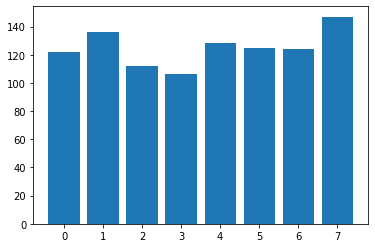

In [216]:
hist = circ.shotsHistogram(1000)

In [217]:
np.zeros((2,2))

array([[0., 0.],
       [0., 0.]])

In [53]:
x = np.array([[0, 1],[1,0]])
I = np.array([[1, 0],[0,1]])
np.dot(x,I)

array([[0, 1],
       [1, 0]])

True


/home/zmorrell/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


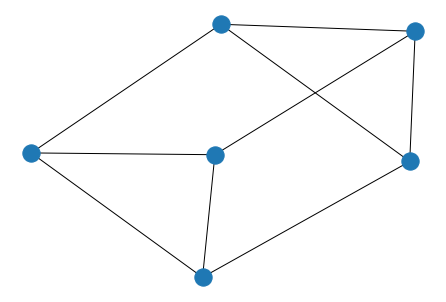

In [38]:
G = nx.generators.random_graphs.random_regular_graph(3,6)
print(nx.is_connected(G))
nx.draw(G)

In [125]:

print(G.nodes)
print(G.edges)
print(G_2.nodes)
G_2=readGraph("graph_example.adjlist")
print(G_2.edges)
sorted(G_2)

(nx.adj_matrix(G_2) - nx.adj_matrix(G)).todense()

[0, 1, 2, 3, 4, 5]
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 5), (2, 4), (3, 4), (3, 5), (4, 5)]
[0, 1, 2, 3, 5, 4]
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 5), (2, 4), (3, 4), (3, 5), (5, 4)]


matrix([[ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1, -1],
        [ 0,  0,  0,  0, -1,  1],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  1, -1,  0,  0,  0],
        [ 0, -1,  1,  0,  0,  0]], dtype=int64)

(1, 0)
(2, 1)
(3, 2)
(4, 3)
(5, 4)
(0, 5)


In [107]:
sorted(G_2)

[0, 1, 2, 3, 4, 5]

In [172]:
def myParsedGraph(path):
    file = open(path,'r')
    G = nx.Graph()
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            G.add_node(int(labels[0]))
    file.seek(0)
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            edges = [(int(labels[0]),int(labels[i])) for i in range(1,len(labels))]
            G.add_edges_from(edges)
    return G

In [173]:
G_mine = myParsedGraph("graph_example.adjlist")

In [174]:
G_mine.edges()

EdgeView([(0, 1), (0, 2), (0, 3), (1, 2), (1, 5), (2, 4), (3, 4), (3, 5), (4, 5)])

In [200]:
vec = np.array([[1, 0]])
mat = np.array([[1,1],[0,1]])

print(vec)
print((np.transpose(vec)))
print(mat)
print(np.matmul(mat,vec.T))
print(np.matmul(vec,np.matmul(mat,vec.T)))

[[1 0]]
[[1]
 [0]]
[[1 1]
 [0 1]]
[[1]
 [0]]
[[1]]


In [205]:
print(graphMatrix(G))
np.sum(graphMatrix(G))

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 2)	1
  (1, 5)	1
  (2, 0)	1
  (2, 1)	1
  (2, 4)	1
  (3, 0)	1
  (3, 4)	1
  (3, 5)	1
  (4, 2)	1
  (4, 3)	1
  (4, 5)	1
  (5, 1)	1
  (5, 3)	1
  (5, 4)	1


18

In [279]:
graphCutBin(G,[1, 0, 1, 0,1,0,1,0])

8.0

In [250]:
vec = np.array([[1,-1,1,-1,1,-1]])
mat = graphMatrix(G)

In [278]:
mat.size

18